In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd


from thesis.model import (
    ScPreGanPipeline,
    VidrSinglePipeline,
    VidrMultiplePipeline,
    ButterflyPipeline,
    ScGenPipeline,
    MultiTaskAaeAutoencoderPipeline,
    MultiTaskAaeAdversarialPipeline,
    MultiTaskAaeAdversarialGaussianPipeline,
    MultiTaskAaeAutoencoderOptimalTransportPipeline,
    MultiTaskAaeAutoencoderAndOptimalTransportPipeline,
    MultiTaskVaeAutoencoderPipeline,
    MultiTaskVaeAutoencoderOptimalTransportPipeline,
    MultiTaskVaeAutoencoderAndOptimalTransportPipeline,
)

multi_task_models = [
    MultiTaskAaeAutoencoderPipeline,
    MultiTaskAaeAdversarialPipeline,
    MultiTaskAaeAdversarialGaussianPipeline,
    MultiTaskAaeAutoencoderOptimalTransportPipeline,
    MultiTaskAaeAutoencoderAndOptimalTransportPipeline,
    MultiTaskVaeAutoencoderPipeline,
    MultiTaskVaeAutoencoderOptimalTransportPipeline,
    MultiTaskVaeAutoencoderAndOptimalTransportPipeline,
]

model_names = {
    "MultiTaskAaeAutoencoderPipeline": "MTAe",
    "MultiTaskAaeAdversarialPipeline": "MTAeAdv",
    "MultiTaskAaeAdversarialGaussianPipeline": "MTAeAdvG",
    "MultiTaskVaeAutoencoderPipeline": "MTVae",
    "MultiTaskAaeAutoencoderOptimalTransportPipeline": "MTAeOT",
    "MultiTaskAaeAutoencoderAndOptimalTransportPipeline": "MTAePlusOT",
    "MultiTaskVaeAutoencoderOptimalTransportPipeline": "MTVaeOT",
    "MultiTaskVaeAutoencoderAndOptimalTransportPipeline": "MTVaePlusOT",
    "ButterflyPipeline": "scButterfly",
    "VidrMultiplePipeline": "vidrMult",
    "VidrSinglePipeline": "vidrSingle",
    "ScGenPipeline": "scGen",
    "ScPreGanPipeline": "scPreGAN",
}

models = [
    ScPreGanPipeline,
    ButterflyPipeline,
    VidrSinglePipeline,
    ScGenPipeline,
] + multi_task_models

multi_models = multi_task_models + [VidrMultiplePipeline]

single_models = [ScPreGanPipeline, ButterflyPipeline, VidrSinglePipeline, ScGenPipeline]


Global seed set to 0
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
from thesis.datasets import (
    NaultPipeline,
    NaultSinglePipeline,
    NaultMultiplePipeline,
    CrossStudyPipeline,
    CrossStudyConditionPipeline,
    CrossSpeciesConditionPipeline,
    CrossSpeciesPipeline,
    PbmcSinglePipeline,
    PbmcPipeline,
)
#dataset_pipeline = CrossSpeciesConditionPipeline(CrossSpeciesPipeline())
dataset_condition_pipelines = [
        PbmcSinglePipeline(PbmcPipeline()),
        CrossSpeciesConditionPipeline(CrossSpeciesPipeline()),
        CrossStudyConditionPipeline(CrossStudyPipeline()),
    ]

In [3]:
dataset_condition_pipelines_dict = {}
for dataset_condition in dataset_condition_pipelines:
    dataset_condition_str = str(dataset_condition)
    dataset_condition_pipelines_dict[dataset_condition_str] = dataset_condition

In [ ]:
from thesis.datasets import SplitDatasetPipeline

top_100degs = {}

def get_eval(dataset_condition_pipeline: SplitDatasetPipeline, seed: int = 1):
    evals_dataset = []
    dataset_condition_pipeline_str = str(dataset_condition_pipeline)
    cell_type_key = dataset_condition_pipeline.cell_type_key 
    cell_types = dataset_condition_pipeline.dataset_pipeline.get_cell_types()
    print(cell_types)

    for model in models:
        if model in multi_task_models and dataset_condition_pipeline_str.startswith("Pbmc"):
            experiment_name = f"bugfix_seed_{seed}"
        else:
            experiment_name = f"seed_{seed}"
            
        multitask = model(
            dataset_pipeline=dataset_condition_pipeline,
            experiment_name=experiment_name,
            seed=seed,
            debug=False,
        )
        
        model_name = model_names[model.__name__]
        
        if model_name not in top_100degs:
            top_100degs[model_name] = {}
            
        if dataset_condition_pipeline_str not in top_100degs[model_name]:
            top_100degs[model_name][dataset_condition_pipeline_str] = {}
            
        for idx, cell_type in enumerate(cell_types):
            eval_adatas = multitask(
                batch=idx,
                append_metrics=False,
                save_plots=False,
                refresh_training=False,
                refresh_evaluation=True,
            )
            
            assert len(eval_adatas) == 1
            eval_adata = eval_adatas[0]
            degs_sti = eval_adata.uns["rank_genes_groups"]["names"]["stimulated"]
            degs_pred = eval_adata.uns["rank_genes_groups"]["names"]["pred"]
            top_100deg = degs_sti[0:100]

            if cell_type not in top_100degs[model_name][dataset_condition_pipeline_str]:
                top_100degs[model_name][dataset_condition_pipeline_str][cell_type] = {}
                
            top_100degs[model_name][dataset_condition_pipeline_str][cell_type] = top_100deg
            eval_adata.obs["model"] = model_name
            eval_adata.obs["dataset"] = str(dataset_condition_pipeline)
            eval_adata.obs["condition_cell_type"] = (
                eval_adata.obs[cell_type_key].astype(str) + "_" + eval_adata.obs["condition"].astype(str)
            )
            evals_dataset.append(eval_adata)
    return evals_dataset


In [ ]:
evals = {}

for dataset_condition_pipeline in dataset_condition_pipelines:
    dataset_condition_pipeline_str = str(dataset_condition_pipeline)
    print(f"Evaluating {dataset_condition_pipeline_str}")
    evals_dataset = get_eval(dataset_condition_pipeline)
    evals[dataset_condition_pipeline_str] = evals_dataset

In [ ]:
from thesis import SAVED_RESULTS_PATH
import pickle
import os

eval_dir = SAVED_RESULTS_PATH / "eval"

eval_dir_datasets = eval_dir / "datasets"

os.makedirs(eval_dir , exist_ok=True)
os.makedirs(eval_dir_datasets , exist_ok=True)

to_load = True

all_adata = {}

if to_load:
    for file_name in os.listdir(eval_dir_datasets):
        print(file_name)
        if file_name.endswith(".h5ad"):
            dataset_condition_pipeline_str = file_name.split(".")[0]
            print(f"Loading {dataset_condition_pipeline_str}")
            adata = sc.read_h5ad(eval_dir_datasets / file_name)
            all_adata[dataset_condition_pipeline_str] = adata
        else:
            raise ValueError(f"File {file_name} is not a .h5ad file")
    with open(eval_dir / "top_100degs_eval.pkl", "rb") as f:
        top_100degs = pickle.load(f)
else:
    for dataset_condition_pipeline_str, evals_dataset in evals.items():
        all_adata[dataset_condition_pipeline_str] = ad.concat(evals_dataset, index_unique=None)
        all_adata[dataset_condition_pipeline_str].obs_names_make_unique()
        all_adata[dataset_condition_pipeline_str].write_h5ad(eval_dir_datasets / f"{dataset_condition_pipeline_str}.h5ad")
    
    with open(eval_dir / "top_100degs_eval.pkl", "wb") as f:
        pickle.dump(top_100degs, f)


CrossSpeciesConditionPipeline_CrossSpeciesPipeline.h5ad
Loading CrossSpeciesConditionPipeline_CrossSpeciesPipeline
CrossStudyConditionPipeline_CrossStudyPipeline.h5ad
Loading CrossStudyConditionPipeline_CrossStudyPipeline
PbmcSinglePipeline_PbmcPipeline.h5ad
Loading PbmcSinglePipeline_PbmcPipeline


In [ ]:
def get_dotplot(model_name: str, dataset_name: str):
    top_genes_threshold = 10

    dataset_adata = all_adata[dataset_name]
    adata = dataset_adata[dataset_adata.obs["model"] == model_name]

    gene_list = top_100degs[model_name]
    gene_list = gene_list[dataset_name]
    cell_types = list(gene_list.keys())

    # what gene list to use?
    gene_list_intersect = set(gene_list[cell_types[0]][:top_genes_threshold])
    for cell_type in cell_types[1:]:
        gene_list_intersect = gene_list_intersect.union(
            set(gene_list[cell_type][:top_genes_threshold])
        )
    gene_list_intersect = list(gene_list_intersect) # this won't be the same across models

    gene_list_scpregan = [
        "NKG7",
        "HLA-DMA",
        "CD7",
        "TNFRSF13B",
        "APOBEC3A",
        "S100A9",
        "CCL5",
        "ISG15",
        "CXCL10",
        "IFITM3",
        "PAF1",
        "CXCL11",
        "RTP4",
        "IRF8",
        "LAG3",
    ]
    gene_list_intersect = gene_list_scpregan

    custom_order = []
    for cell_type in cell_types:
        for condition in ["control", "pred", "stimulated"]:
            custom_order.append(f"{cell_type}_{condition}")

    adata.obs["condition_cell_type"] = pd.Categorical(
        adata.obs["condition_cell_type"], categories=custom_order, ordered=True
    )

    adata = adata[adata.obs.sort_values(["condition_cell_type"]).index]

    sc.pl.dotplot(
        adata,
        groupby="condition_cell_type",
        var_names=gene_list_intersect,
        use_raw=False,
    )

In [ ]:
dataset_name = "PbmcSinglePipeline_PbmcPipeline"
get_dotplot("scPreGAN", dataset_name)
get_dotplot("scButterfly", dataset_name)
get_dotplot("vidrSingle", dataset_name)
get_dotplot("scGen", dataset_name)
get_dotplot("MTAe", dataset_name)

In [65]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from typing import List

# Parameters
datasets = [
    "PbmcSinglePipeline_PbmcPipeline",
    # "CrossStudyConditionPipeline_CrossStudyPipeline",
    # "CrossSpeciesConditionPipeline_CrossSpeciesPipeline",
]


def get_dotplots_models(dataset_name: str, models: List[str], gene_list: List[str]):

    datasets = [dataset_name]

    fig, axes = plt.subplots(
        nrows=len(datasets),
        ncols=len(models),
        figsize=(8 * len(models), 6 * len(datasets)),
        squeeze=False
    )

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            ax = axes[i][j]

            dataset_adata = all_adata[dataset]
            adata = dataset_adata[dataset_adata.obs["model"] == model]

            gene_list_dict = top_100degs[model][dataset]
            cell_types = list(gene_list_dict.keys())

            # top_genes_threshold = 10
            # gene_set = set()
            # for ct in cell_types:
            #     gene_set.update(gene_list_dict[ct][:top_genes_threshold])
            # gene_list = list(gene_set)
            

            custom_order = [f"{ct}_{cond}" for ct in cell_types for cond in ["control", "pred", "stimulated"]]
            adata.obs["condition_cell_type"] = pd.Categorical(
                adata.obs["condition_cell_type"], categories=custom_order, ordered=True
            )
            adata = adata[adata.obs.sort_values("condition_cell_type").index]

            dotplot = sc.pl.dotplot(
                adata,
                groupby="condition_cell_type",
                var_names=gene_list,
                use_raw=False,
                ax=ax,
                show=False,
                return_fig=False,
            )
            
            #dotplot.legend(show=False)
            is_last_one = (i == len(datasets) - 1) and (j == len(models) - 1)
            dotplot["size_legend_ax"].set_visible(is_last_one)
            dotplot["color_legend_ax"].set_visible(is_last_one)

            if i == 0:
                ax.set_title(model)
            if j == 0:
                ax.set_ylabel(dataset)

    #plt.tight_layout()
    plt.show()


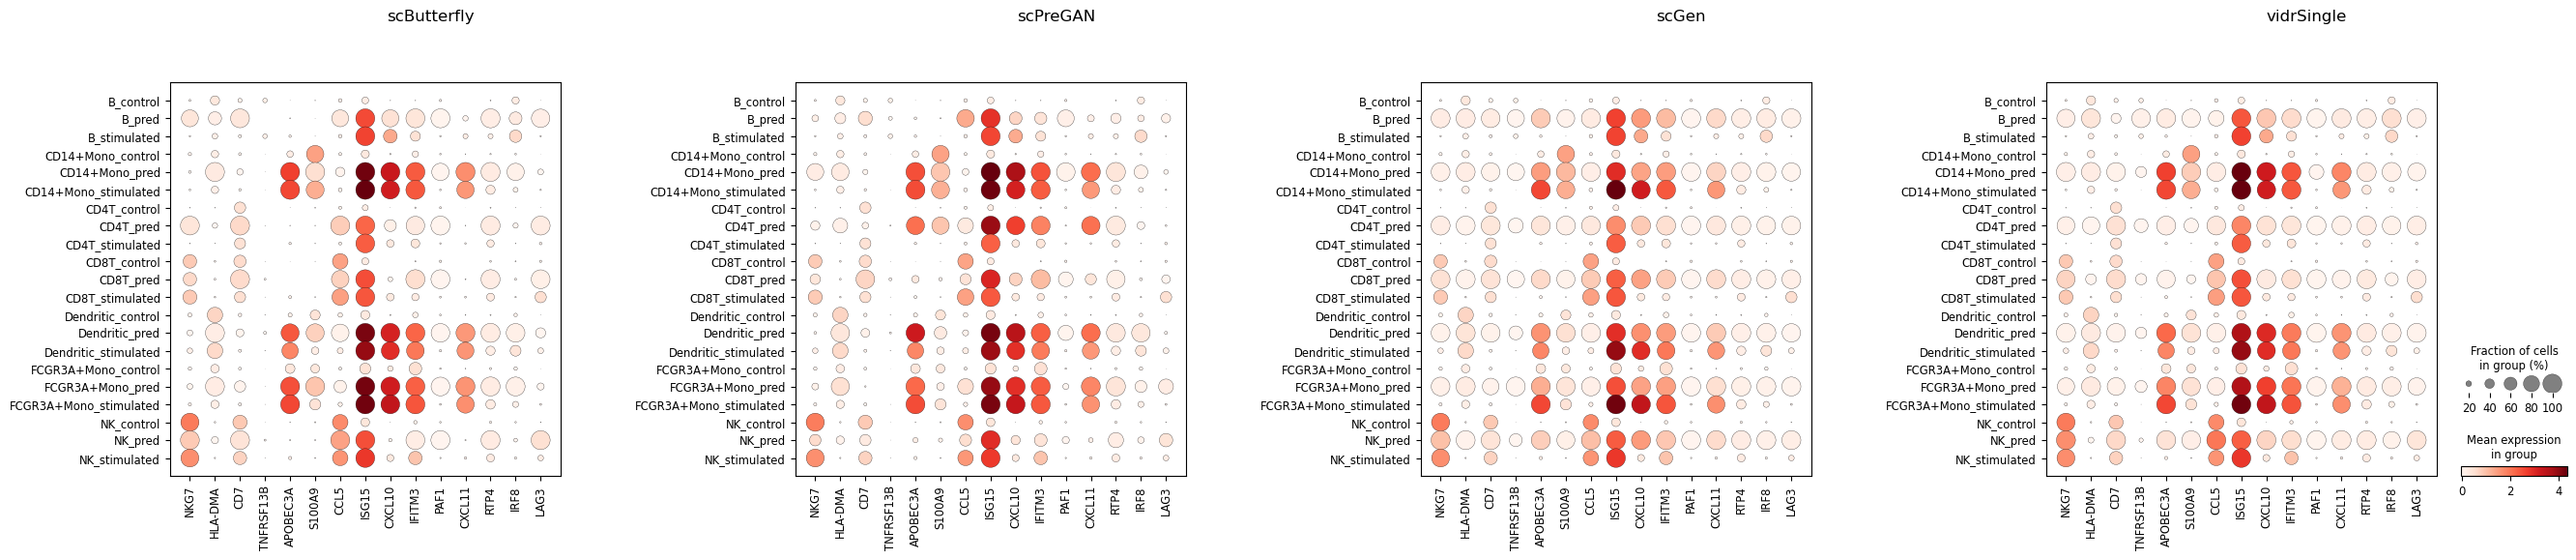

In [70]:
models = [
    "scButterfly",
    "scPreGAN",
    "scGen",
    "vidrSingle",
]
gene_list_scpregan = [
    "NKG7",
    "HLA-DMA",
    "CD7",
    "TNFRSF13B",
    "APOBEC3A",
    "S100A9",
    "CCL5",
    "ISG15",
    "CXCL10",
    "IFITM3",
    "PAF1",
    "CXCL11",
    "RTP4",
    "IRF8",
    "LAG3",
]

get_dotplots_models(dataset_name="PbmcSinglePipeline_PbmcPipeline", models=models, gene_list=gene_list_scpregan)

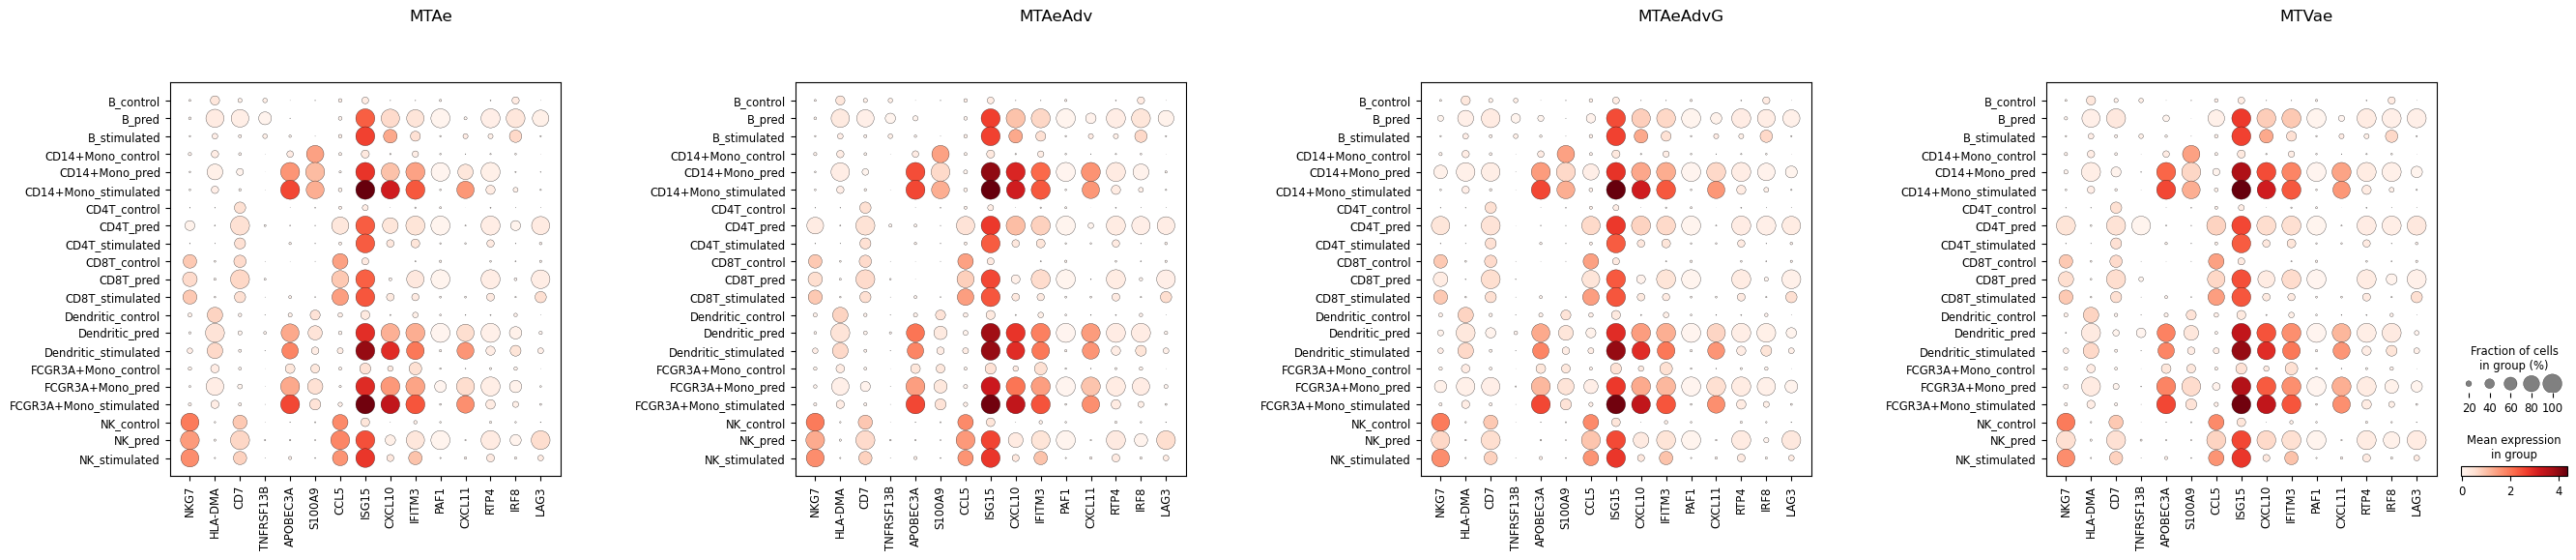

In [69]:
models = [
    "MTAe",
    "MTAeAdv",
    "MTAeAdvG",
    "MTVae",

]
get_dotplots_models(dataset_name="PbmcSinglePipeline_PbmcPipeline", models=models, gene_list=gene_list_scpregan)

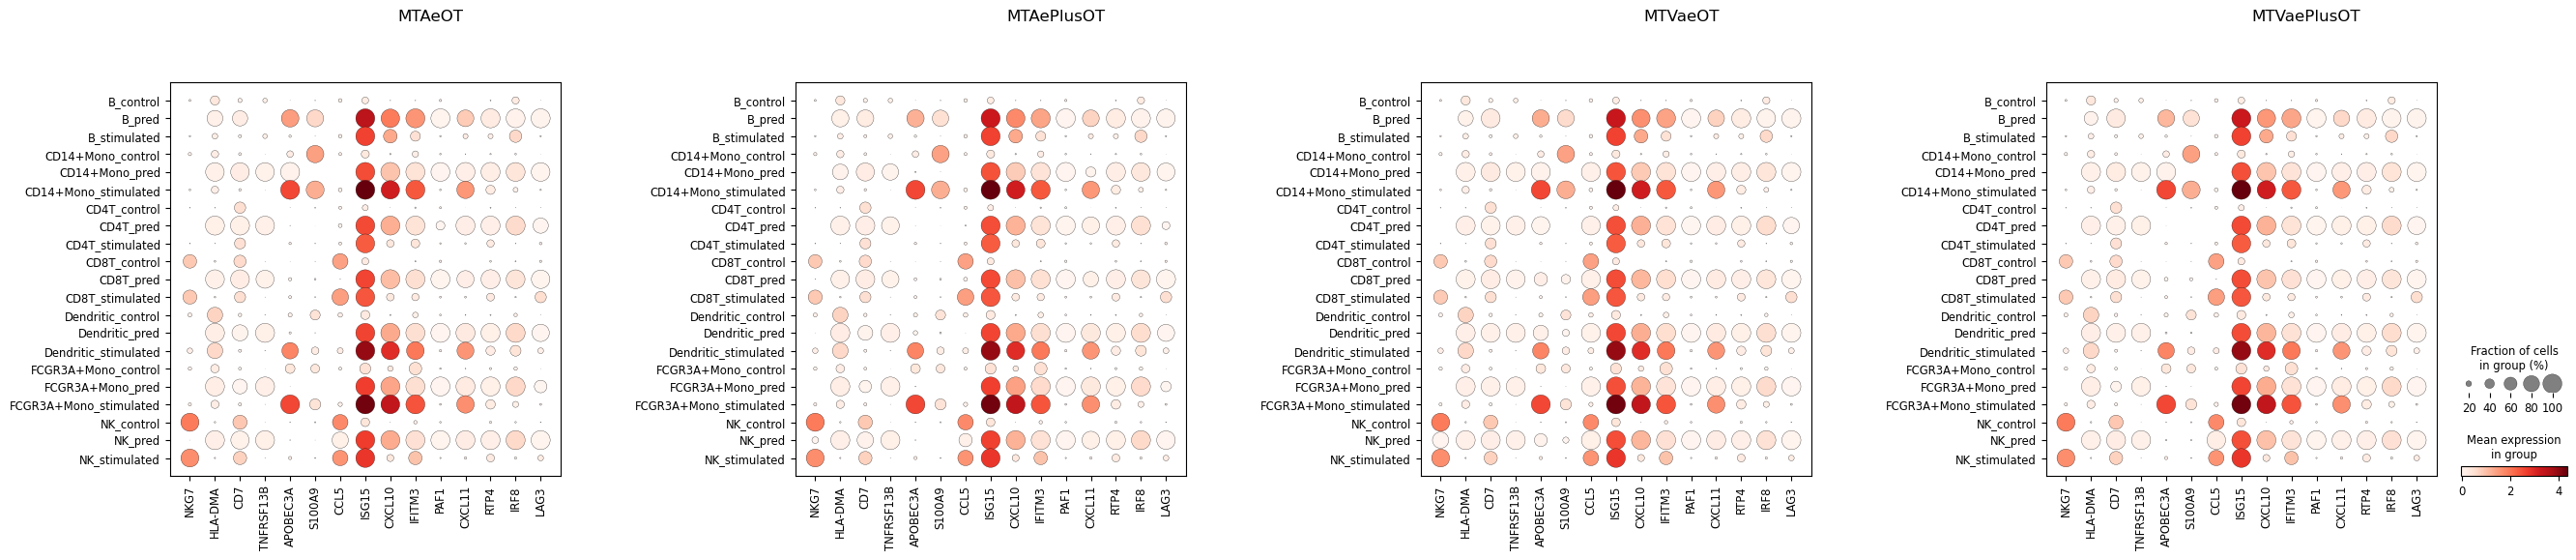

In [68]:
models = [
    "MTAeOT",
    "MTAePlusOT",
    "MTVaeOT",
    "MTVaePlusOT",
]
get_dotplots_models(dataset_name="PbmcSinglePipeline_PbmcPipeline", models=models, gene_list=gene_list_scpregan)

In [10]:
def get_violin(dataset_name: str, cell_type: str, gene: str):
    dataset_adata = all_adata[dataset_name]
    cell_type_key = dataset_condition_pipelines_dict[dataset_name].cell_type_key
    all_adata_cell_type = dataset_adata[dataset_adata.obs[cell_type_key] == cell_type]
    
    ctrl = all_adata_cell_type[all_adata_cell_type.obs["condition"] == "control"]
    pred = all_adata_cell_type[all_adata_cell_type.obs["condition"] == "pred"]
    sti = all_adata_cell_type[all_adata_cell_type.obs["condition"] == "stimulated"]
    
    pred.obs["condition"] = pred.obs["model"]

    violin_adata = ad.concat([ctrl, pred, sti])
    
    sc.pl.violin(
        violin_adata,
        groupby="condition",
        keys=gene,
        rotation=90,
        order=["control", "stimulated"] + [model_names[model.__name__] for model in models],
        show=True
    )
    return violin_adata

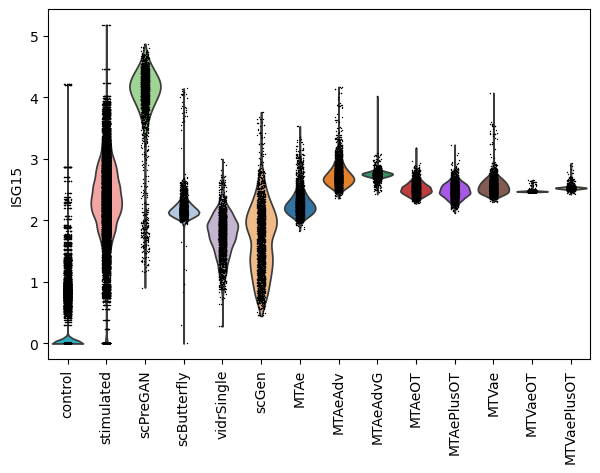

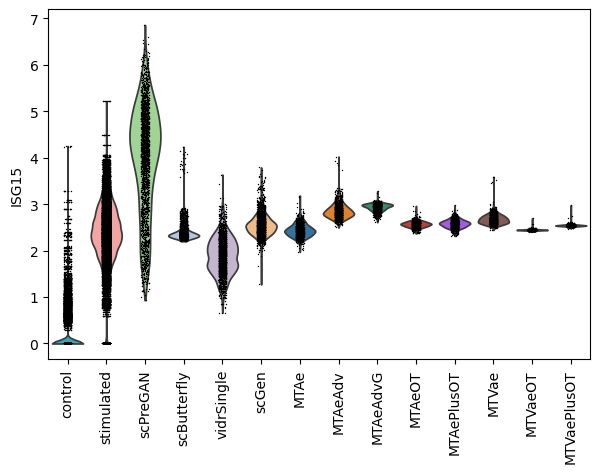

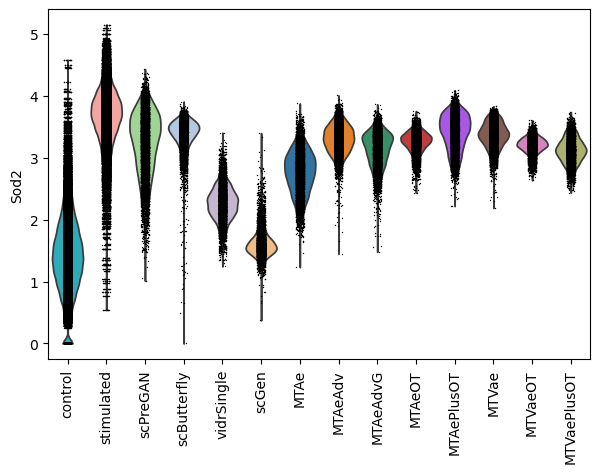

In [11]:
violin_adata = get_violin(dataset_name="PbmcSinglePipeline_PbmcPipeline", cell_type="CD4T", gene="ISG15")
violin_adata = get_violin(dataset_name="CrossStudyConditionPipeline_CrossStudyPipeline", cell_type="CD4 T cells", gene="ISG15")
violin_adata = get_violin(dataset_name="CrossSpeciesConditionPipeline_CrossSpeciesPipeline", cell_type="rat", gene="Sod2")

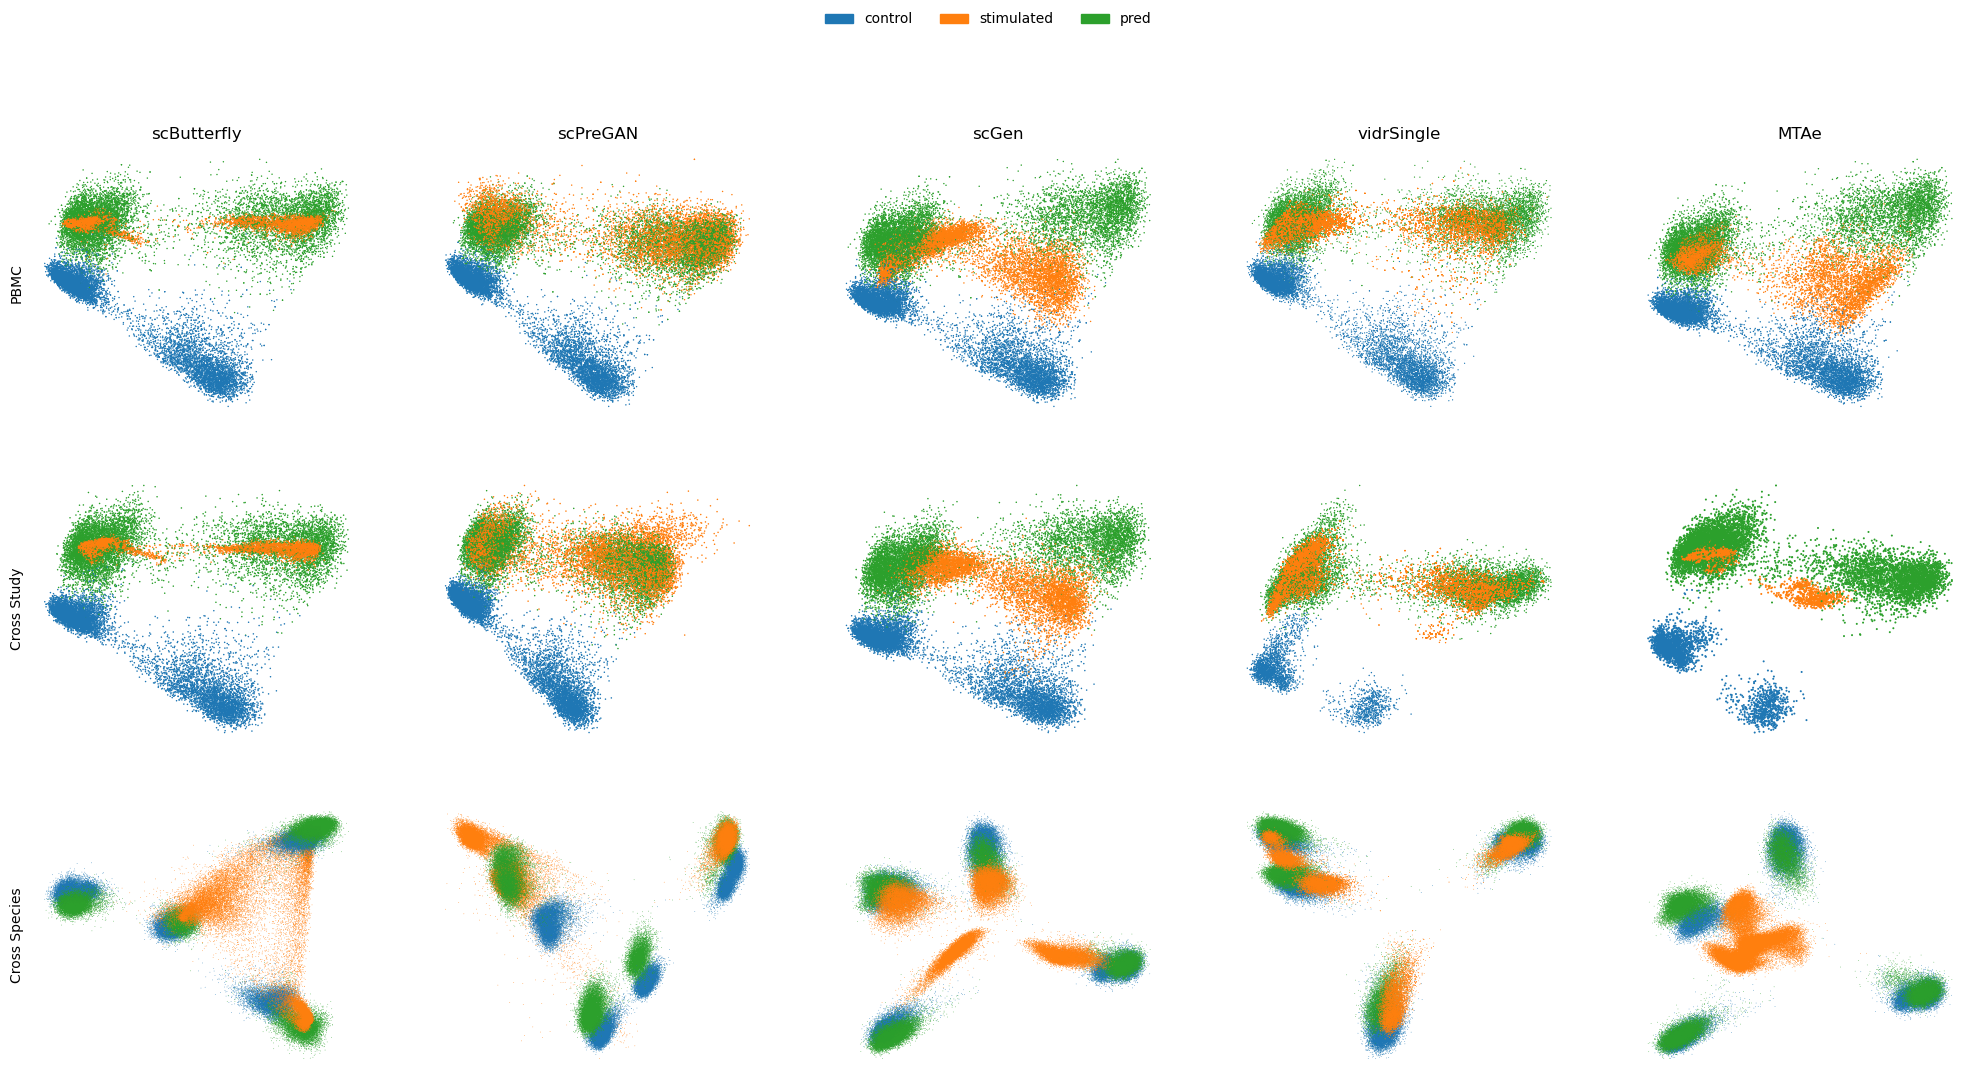

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

condition_colors = {
    "control": "#1f77b4",
    "stimulated": "#ff7f0e",
    "pred": "#2ca02c",
}

# Create legend handles (colored squares with labels)
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in condition_colors.items()
]

# Your inputs
datasets = [
    "PbmcSinglePipeline_PbmcPipeline",
    "CrossStudyConditionPipeline_CrossStudyPipeline",
    "CrossSpeciesConditionPipeline_CrossSpeciesPipeline",
]

ylabel = {
    "PbmcSinglePipeline_PbmcPipeline": "PBMC",
    "CrossStudyConditionPipeline_CrossStudyPipeline": "Cross Study",
    "CrossSpeciesConditionPipeline_CrossSpeciesPipeline": "Cross Species",
}

models = [
    "scButterfly",
    "scPreGAN",
    "scGen",
    "vidrSingle",
    "MTAe"
]

fig, axes = plt.subplots(
    nrows=len(datasets), ncols=len(models), figsize=(5 * len(models), 4 * len(datasets))
)

if len(datasets) == 1 or len(models) == 1:
    axes = axes.flatten()

for row_idx, dataset in enumerate(datasets):
    for col_idx, model in enumerate(models):
        ax = axes[row_idx][col_idx] if len(datasets) > 1 else axes[col_idx]

        all_adata_dataset = all_adata[dataset]
        all_adata_model = all_adata_dataset[all_adata_dataset.obs["model"] == model]

        sc.tl.pca(all_adata_model)
        ax_pca = sc.pl.pca(
            all_adata_model,
            color="condition",
            frameon=True,
            ax=ax,
            show=False,
            legend_loc=None,
        )

        ax.tick_params(left=False, bottom=False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_xlabel("")

        if row_idx == 0:
            ax.set_title(model)
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(ylabel[dataset])
        else:
            ax.set_ylabel("")

fig.legend(handles=legend_handles, loc="upper center", ncol=len(legend_handles), frameon=False)
#plt.tight_layout()
plt.show()

In [20]:
def get_pca(dataset_name: str, model_name: str):
    all_adata_dataset = all_adata[dataset_name]
    #all_adata_cell_type = all_adata_dataset[all_adata_dataset.obs["cell_type"] == cell_type]
    
    all_adata_model = all_adata_dataset[all_adata_dataset.obs["model"] == model_name]
    
    sc.tl.pca(all_adata_model)
    fig = sc.pl.pca(
        all_adata_model,
        color="condition",
        frameon=False,
        return_fig=True,
        show=False,
    )
    return fig

In [ ]:
get_pca(dataset_name="PbmcSinglePipeline_PbmcPipeline", model_name="scPreGAN")